<a href="https://colab.research.google.com/github/xdderekchen/ML/blob/master/ABM_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Simulation Framework using Agent-Based model with Monte Carlo method.

In this post, we will build a simulation framework to study the potential disease spread if there is no control.

The simulation framework is an agent based model, using the MESA package https://mesa.readthedocs.io/en/master/

## Plan:
 1. Environment  10 x 10 (N x N) grid, consists of 100 cells. 
 2. There are 100 (NA) Agents which are randomly assigned to cells.
 3. At each step, an agent can do one (only one) of the following things:
   
   3.1. an agent can move to adjacent cell (with a higher probability of staying in the same cell)
   
   3.2. an agent with a disease can pass the disease [with a probability (the statistical distribution can be set as runtime configuration)] to another agent at the SAME cell.
 4. Randomly select an agent with the disease.
 5. we want to plot the grid, after M steps, to see the spread of disease.
 


In [0]:
#### https://mesa.readthedocs.io/en/master/best-practices.html
!pip install mesa
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.batchrunner import BatchRunner

from mesa.datacollection import DataCollector

DS_T_Lmt0 = 3   #start to trasmit the SS
DS_T_Lmt1 = 6   #sympoton is obvious, not allow to move around

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

class DSAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.Days_SS = 0
        self.is_SS = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        if self.Days_SS < DS_T_Lmt1:
            self.model.grid.move_agent(self, new_position)

    def transfer_DS(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            if self.Days_SS>=DS_T_Lmt0:
               if other.is_SS == 0:
                  other.is_SS = 1;
        return None
          
    def step(self):
        self.move()
        self.transfer_DS()
        if self.is_SS == 1:
           self.Days_SS += 1

class DSModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = DSAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
           # model_reporters={"Gini": compute_gini},
           # agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

245it [02:04,  1.02it/s]


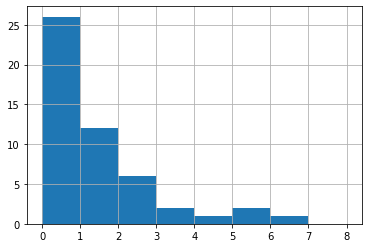

In [0]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()
gini = model.datacollector.get_model_vars_dataframe()
#gini.plot()

agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

end_wealth = agent_wealth.xs(99, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))


fixed_params = {
    "width": 10,
    "height": 10
}

variable_params = {"N": range(10, 500, 10)}

# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    MoneyModel,
    variable_params,
    fixed_params,
    iterations=5,
    max_steps=100,
    model_reporters={"Gini": compute_gini}
)

batch_run.run_all()




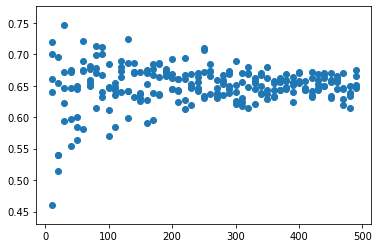

In [0]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)

[7, 10, 9, 10, 15, 7, 10, 10, 8, 14]


(array([2., 1., 1., 4., 0., 0., 0., 0., 1., 1.]),
 array([ 7. ,  7.8,  8.6,  9.4, 10.2, 11. , 11.8, 12.6, 13.4, 14.2, 15. ]),
 <a list of 10 Patch objects>)

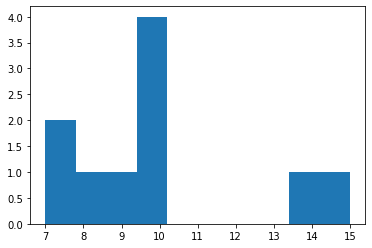

In [0]:
model = MoneyModel(10)
for i in range(10):
    model.step()

# For a jupyter notebook add the following line:
%matplotlib inline

# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
print(agent_wealth)
plt.hist(agent_wealth)

(array([  1.,   0.,   0.,   4.,  24.,  32.,  70.,  75., 119., 121., 135.,
        102., 119.,  64.,  66.,  33.,  15.,   9.,  11.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 19 Patch objects>)

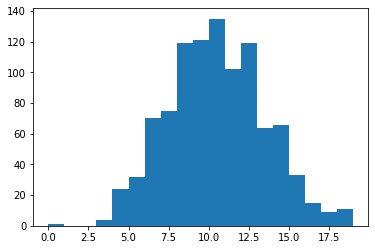

In [0]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))